<a href="https://colab.research.google.com/github/apof/Information-Retrieval---Data-Mining-/blob/main/IRDM_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt

%matplotlib inline

**Load The Data and Process the with Pandas DataFrames**

In [3]:
train_data_file = "drive/MyDrive/Datasets/IRDM/train_data.tsv"
test_data_file = "drive/MyDrive/Datasets/IRDM/validation_data.tsv"

In [4]:
col_names=['qid','pid','query','passage','relevancy']

train_data_init=pd.read_csv(train_data_file, sep='\t', header=None, names=col_names)
train_data_df=pd.DataFrame(train_data_init)
train_data_df = train_data_df.iloc[1:]

test_data_init=pd.read_csv(test_data_file, sep='\t', header=None, names=col_names)
test_data_df=pd.DataFrame(test_data_init)
test_data_df = test_data_df.iloc[1:]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
train_data_df["relevancy"] = train_data_df.relevancy.astype(float)
test_data_df["relevancy"] = test_data_df.relevancy.astype(float)

In [7]:
train_labels = train_data_df['relevancy'].values
test_labels = test_data_df['relevancy'].values

In [8]:
train_passages = train_data_df['passage'].values
train_queries = train_data_df['query'].values
train_pids = train_data_df['pid'].values
train_qids = train_data_df['qid'].values

In [9]:
test_passages = test_data_df['passage'].values
test_queries = test_data_df['query'].values
test_pids = test_data_df['pid'].values
test_qids = test_data_df['qid'].values

**Create Dictionaries for the Training and Testing Data**

In [10]:
train_passage_dict = {}
train_query_dict = {}
for i, _ in enumerate(train_queries):
  train_passage_dict[train_pids[i]] = train_passages[i]
  train_query_dict[train_qids[i]] = train_queries[i]

In [11]:
test_passage_dict = {}
test_query_dict = {}
for i, _ in enumerate(test_queries):
  test_passage_dict[test_pids[i]] = test_passages[i]
  test_query_dict[test_qids[i]] = test_queries[i]

**Correct Imbalanced Data with Negative Sampling**

In [12]:
def collect_relevant_pids(pids,qids,relevancy):

  relevancy_dict = {}
  ## collect for each query all the relevant passages (relevant passages is the minority class)
  ## and then sample randomply K negative examples

  for i, qid in enumerate(qids):
    if(relevancy_dict.get(qid) == None):
      if(relevancy[i] == 0):
        relevancy_dict[qid] = [[],[(pids[i],i)]]
      else:
        relevancy_dict[qid] = [[(pids[i],i)],[]]
    else:
      l = relevancy_dict.get(qid)
      if(relevancy[i] == 0):
        l[1].append((pids[i],i))
      else:
        l[0].append((pids[i],i))
      relevancy_dict[qid] = l

  return relevancy_dict

In [13]:
train_relevant_passages_dict = collect_relevant_pids(train_pids,train_qids,train_labels)

In [14]:
test_relevant_passages_dict = collect_relevant_pids(test_pids,test_qids,test_labels)

In [15]:
def negative_sampling(relevant_passages_dict,passage_dict,query_dict,K):

  sampled_passages = []
  sampled_queries = []
  sampled_labels = []
  sampled_qids = []
  sampled_pids = []


  for key in relevant_passages_dict:
    l = relevant_passages_dict.get(key)

    number_of_positive_samples = len(l[0])
    number_of_negative_passages = len(l[1])

    #print("query " + str(key) + " has " + str(number_of_positive_samples) + " positive and " + str(number_of_negative_passages) + " negative sample" )

    ## if there are not relevant passages continue
    if(number_of_positive_samples != 0):
      ## collect all relevant passages
      for (pid,_) in l[0]:
        sampled_queries.append(query_dict.get(key))
        sampled_passages.append(passage_dict.get(pid))
        sampled_labels.append(1)
        sampled_qids.append(key)
        sampled_pids.append(pid)

      negative_examples_to_draw = None
      ## if the positive examples for a query are more than the negative one --> select all the negative and add them to the dataset
      if(number_of_positive_samples >= number_of_negative_passages):
        negative_examples_to_draw = number_of_negative_passages
      else:
        ## if there are more negative examples than K
        if(number_of_negative_passages >= K):
          negative_examples_to_draw = K
        else:
          ## elese collect all the negaative examples
          negative_examples_to_draw = number_of_positive_samples

      ## select a number of negative samples equal to the number of the positive ones
      indexes = random.sample(range(0,number_of_negative_passages), negative_examples_to_draw)

      for i in indexes:
        sampled_queries.append(query_dict.get(key))
        sampled_passages.append(passage_dict.get(l[1][i][0]))
        sampled_labels.append(-1)
        sampled_qids.append(key)
        sampled_pids.append(l[1][i][0])

  return sampled_passages, sampled_queries, sampled_labels, sampled_pids, sampled_qids


In [16]:
## how many negative samples to collect for each positive one
K = 5

In [17]:
sampled_passages, sampled_queries, sampled_labels, sampled_pids, sampled_qids = negative_sampling(train_relevant_passages_dict,train_passage_dict,train_query_dict,K)

**Evaluation Metrics Mean Precision and NDCG**

In [50]:
def Average_Precision(predictions,test_labels,test_query_dict,test_relevant_passages_dict):

  average_precision = 0
  queries_num = 0

  for key in test_query_dict:
    
    relevant_docs = test_relevant_passages_dict.get(key)[0]
    irrelevant_docs = test_relevant_passages_dict.get(key)[1]
    if(len(relevant_docs) != 0):
      queries_num += 1
      ### based on all the candidate passages create a list with tuples (ranking,label)
      #print(str(key) + " " + str(len(relevant_docs)) + "  " + str(len(irrelevant_docs)))
      ranking_list = []
      for (_,index) in relevant_docs + irrelevant_docs:
        ranking = None
        if(predictions[index] == None):
          ranking = 0
        else:
          ranking = predictions[index]
        ranking_list.append((ranking,test_labels[index]))
      ## get the top 100 docs
      sorted_ranking = sorted(ranking_list, key=lambda tup: tup[0], reverse = True)
      sorted_ranking = sorted_ranking[0:100]
      indx = 1
      precision = []
      relevant_docs_found = 0
      for (_,label) in sorted_ranking:
        if(label == 1):
          #print("relevant doc ranked  at " + str(indx))
          relevant_docs_found += 1
        precision.append(relevant_docs_found/indx)
        indx += 1
      query_precision = np.sum(np.array(precision))/len(sorted_ranking)
      #print("Precision for query " + str(key) + " is " + str(query_precision))

      average_precision += query_precision

  print("Average Precision: " + str(average_precision/queries_num))   

In [51]:
def Average_NDCG(predictions,test_labels,test_query_dict,test_relevant_passages_dict):

  average_ndcg = 0
  queries_num = 0

  for key in test_query_dict:
    relevant_docs = test_relevant_passages_dict.get(key)[0]
    irrelevant_docs = test_relevant_passages_dict.get(key)[1]
    if(len(relevant_docs) != 0):

      queries_num += 1

      ## compute IDCG
      IDCG = 0
      for i in range(len(relevant_docs)):
        IDCG += 1/(np.log2((i+1)+1))

      ranking_list = []
      for (_,index) in relevant_docs + irrelevant_docs:
        ranking = None
        if(predictions[index] == None):
          ranking = 0
        else:
          ranking = predictions[index]
        ranking_list.append((ranking,test_labels[index]))
      ## get the top 100 docs
      sorted_ranking = sorted(ranking_list, key=lambda tup: tup[0], reverse = True)
      sorted_ranking = sorted_ranking[0:100]

      ## compute DCG
      DCG = 0
      for i,(_,label) in enumerate(sorted_ranking):
        if(label == 1):
          DCG += 1/(np.log2((i+1)+1))

      average_ndcg += DCG/IDCG

  print("Average NDCG: " + str(average_ndcg/queries_num))

**BM25 Retrieval Method**

In [ ]:
## immport useful utilities from previous coursework
import sys
sys.path.insert(0,'drive/MyDrive/Src/')
import Utils
import RetrievalMethods

In [ ]:
preprocessed_queries_dict = Utils.preprocess_queries(test_query_dict)

In [ ]:
## create candidate passage dict
def get_candidate_passages(test_relevant_passages_dict):
  index_dict = {}
  query_passage_dict ={}
  for key in test_relevant_passages_dict:
    l = test_relevant_passages_dict.get(key)
    for (pid,ind) in l[0] + l[1]:
      if(query_passage_dict.get(key) == None):
        query_passage_dict[key] = [pid]
      else:
        query_passage_dict[key].append(pid)
      index_dict[(key,pid)] = ind

  return query_passage_dict, index_dict

In [ ]:
query_passage_dict, index_dict = get_candidate_passages(test_relevant_passages_dict)

In [ ]:
preprocessed_passages, passage_ids, preprocessed_candidates_dict = Utils.preprocess_passages(877810,test_passage_dict,query_passage_dict,'query')


In [ ]:
inverted_index, index_token_dictionary = Utils.inverted_index(preprocessed_passages,passage_ids)

In [ ]:
def get_BM25_score(queries_dict,passages_dict,query_passage_dict):
  results_dict = {}
  i = 0
  for key in queries_dict:
    i+=1
    print("Processing query: " + str(i)+'/'+str(len(queries_dict)))
    clear_output(wait=True)      
    preprocessed_passages, passage_ids, preprocessed_candidates_dict = Utils.preprocess_passages(key,passages_dict,query_passage_dict,'query')
    inverted_index, token_index_dictionary = Utils.inverted_index(preprocessed_passages,passage_ids)
    ranking = RetrievalMethods.BM25_Model(key,queries_dict,inverted_index,preprocessed_candidates_dict)
    for (pid,score) in ranking:
      results_dict[(key,pid)] = score

  return results_dict


In [ ]:
results_dict = get_BM25_score(preprocessed_queries_dict,test_passage_dict,query_passage_dict)

Processing query: 2292/2292


In [ ]:
predictions = []
for i,qid in enumerate(test_qids):
  predictions.append(results_dict.get((qid,test_pids[i])))

In [ ]:
Average_Precision(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average Precision: 0.022834793288548517


In [ ]:
Average_NDCG(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average NDCG: 0.3118983295937294


**Preprocess Data and data Modeling for ML Ranking Methods**

In [18]:
import joblib
from IPython.display import clear_output
import numpy as np
import re
import gensim
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import  WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [19]:
EMBEDDING_SIZE = 300

In [20]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-04-16 19:16:08--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.27.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.27.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.0MB/s    in 46s     

2021-04-16 19:16:55 (34.0 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [21]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [22]:
def process_data(data,rm_stopwords = True, lemm = True):
	stop_words = set(stopwords.words('english'))
	## remove punctuation
	tokenizer = RegexpTokenizer(r'\w+')
	processed_sentences = []
	for sentence in data:
		## tokenise each sentence
		tokenised_sentence = tokenizer.tokenize(sentence)
		##convert to lower case
		sentence = [w.lower() for w in tokenised_sentence]
		##exclude non alphabetic words
		only_alpha_sentence = [word for word in sentence if word.isalpha()]
		## remove stop words
		if(rm_stopwords == True):
			filtered_sentence = [w for w in only_alpha_sentence if not w in stop_words]
		else:
			filtered_sentence = only_alpha_sentence
		lemmatized_sentence = []
		if(lemm == True):
			## stemming
			lemmatizer = WordNetLemmatizer()
			#stemmer = PorterStemmer()
			for word in filtered_sentence:
				lemmatized_sentence.append(lemmatizer.lemmatize(word))
				#lemmatized_sentence.append(stemmer.stem(word))
		else:
			lemmatized_sentence = filtered_sentence

		processed_sentences.append(lemmatized_sentence)
	return processed_sentences

In [23]:
train_passages = process_data(sampled_passages)
train_queries = process_data(sampled_queries)
test_passages = process_data(test_passages)
test_queries = process_data(test_queries)

In [24]:
print(len(train_passages))
print(len(train_queries))

print(len(test_passages))
print(len(test_queries))

27713
27713
1103039
1103039


In [25]:
max_l = 0
for sentence in train_passages:
  if(len(sentence) > max_l):
    max_l = len(sentence)
for sentence in train_queries:
  if(len(sentence) > max_l):
    max_l = len(sentence)
for sentence in test_passages:
  if(len(sentence) > max_l):
    max_l = len(sentence)
for sentence in test_queries:
  if(len(sentence) > max_l):
    max_l = len(sentence)
print(max_l)

138


In [26]:
def find_unique_words(datasets):

  # words to indexes
  vocab_words = {}
  # indexes to embeddings
  vocab_embeddings = {}

  unique_words = 0

  # for every data set training validation testing
  for dataset in datasets:
    # for every sentence
    for sentence in dataset:
      # for each word of the sentence
      for word in sentence:
        # if this word is not saved on the dictionary
        if(vocab_words.get(word)==None):
          # if this word exists is the word Word2Vec model
          if word in word2vec:
            unique_words += 1
            vocab_words[word] = unique_words
            vocab_embeddings[unique_words] = word2vec.wv[word]

  return vocab_words,vocab_embeddings

In [27]:
## vocab dict --> key each unique word and value a unique id
## embeddings dict --> key the unique id of a word and value the respective embedding
vocab_dict,vocab_embeddings_dict = find_unique_words([train_passages,train_queries,test_passages,test_queries])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


**Model Data for the Logistic Regression and the XGBOOST**

In [28]:
def get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,sentences):
  representations = []
  ## for every sentence
  for sentence in sentences:
    sentence_representation = []
    for word in sentence:
      ## collect all the word embeddings of the respective words of a sentence
      word_index = vocab_dict.get(word)
      if(word_index!=None):
        word_embedding = vocab_embeddings_dict.get(word_index)
        sentence_representation.append(np.array(word_embedding))
      else:
        sentence_representation.append(np.array(np.zeros(EMBEDDING_SIZE)))
    if(len(sentence_representation) == 0):
      sentence_representation.append(np.array(np.zeros(EMBEDDING_SIZE)))
    sentence_representation = np.array(sentence_representation)

    representations.append(np.mean(sentence_representation,axis = 0))

  return np.array(representations)

In [29]:
train_passage_represenations = get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,train_passages)
train_queries_represenations = get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,train_queries)

test_passage_represenations = get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,test_passages)
test_queries_represenations = get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,test_queries)

In [30]:
print(train_passage_represenations.shape)
print(train_queries_represenations.shape)

print(test_passage_represenations.shape)
print(test_queries_represenations.shape)

(27713, 300)
(27713, 300)
(1103039, 300)
(1103039, 300)


In [31]:
def combine_representations(q_rep,p_rep,flag = 'diff'):
  representation = []
  for i,p in enumerate(p_rep):
    if(flag == 'diff'):
      representation.append((p - q_rep[i])**2)
    else:
      representation.append(np.concatenate((p,q_rep[i]),axis = 0))
  return np.array(representation)


In [32]:
train_inputs = combine_representations(train_queries_represenations,train_passage_represenations,flag = 'diff')

test_inputs = combine_representations(test_queries_represenations,test_passage_represenations,flag = 'diff')

In [41]:
print(train_inputs.shape)
print(train_labels.shape)
print(test_inputs.shape)
print(test_labels.shape)

(0,)
(0,)


In [34]:
joblib.dump(train_inputs, 'drive/MyDrive/Vectors/train_inputs')
joblib.dump(test_inputs, 'drive/MyDrive/Vectors/test_inputs')

joblib.dump(sampled_labels, 'drive/MyDrive/Vectors/train_labels')
joblib.dump(test_labels, 'drive/MyDrive/Vectors/test_labels')

['drive/MyDrive/Vectors/test_labels']

**Modeling Data for the Neural Network**

In [41]:
def create_look_up_table(embeddings_dict):

  look_up_table = [np.zeros(300)]
  for key in sorted (embeddings_dict.keys()) :  
     look_up_table.append(embeddings_dict.get(key))
  return np.array(look_up_table) 

In [28]:
def padding_at_the_end_V2(max_length,vector):

  vector = np.array(vector)

  if(vector.shape[0] < max_length and vector.shape[0] != 0):
    padding_vector = np.zeros(max_length - vector.shape[0])
    return np.concatenate((vector, padding_vector), axis=0)
  elif(vector.shape[0] == max_length):
    return vector
  else:
    return np.zeros((0,0))

In [35]:
def convert_to_embeddings_V2(data,max_length,labels,vocab_words):

  embedding_list = []
  embedding_labels = []
  count = -1

  for sentence in data:
    count += 1
    embedding_sentence = []
    for word in sentence:
      if(vocab_words.get(word)!=None):
        #word_one_hot_encoding = np.zeros(len(vocab_words))
        #word_one_hot_encoding[vocab_words.get(word)] = 1
        embedding_sentence.append(vocab_words.get(word))

    embedding_sentence =  padding_at_the_end_V2(max_length,embedding_sentence) 

    if(embedding_sentence.shape[0]!=0):
      embedding_labels.append(labels[count])
      embedding_list.append(np.array(embedding_sentence))
    else:
      embedding_labels.append(labels[count])
      embedding_list.append(np.zeros(max_length))
  
  return np.array(embedding_list),np.array(embedding_labels)

In [38]:
train_inputs_passages,train_labels = convert_to_embeddings_V2(train_passages,max_l,sampled_labels,vocab_dict)
train_inputs_queries,_ = convert_to_embeddings_V2(train_queries,max_l,sampled_labels,vocab_dict)

test_inputs_passages,test_labels = convert_to_embeddings_V2(test_passages,max_l,test_labels,vocab_dict)
test_inputs_queries,_ = convert_to_embeddings_V2(test_queries,max_l,test_labels,vocab_dict)

In [39]:
print(train_inputs_passages.shape)
print(train_inputs_queries.shape)

print(test_inputs_passages.shape)
print(test_inputs_queries.shape)

(27713, 138)
(27713, 138)
(1103039, 138)
(1103039, 138)


In [42]:
look_up_table = create_look_up_table(vocab_embeddings_dict)
print(look_up_table.shape)

(84345, 300)


In [44]:
joblib.dump(train_inputs_passages, 'drive/MyDrive/Vectors/train_inputs_passages')
joblib.dump(train_inputs_queries, 'drive/MyDrive/Vectors/train_inputs_queries')

joblib.dump(test_inputs_passages, 'drive/MyDrive/Vectors/test_inputs_passages')
joblib.dump(test_inputs_queries, 'drive/MyDrive/Vectors/test_inputs_queries')

['drive/MyDrive/Vectors/test_inputs_queries']

**Logistic Regression**

In [44]:
train_inputs = joblib.load('drive/MyDrive/Vectors/train_inputs')
train_labels = np.array(joblib.load('drive/MyDrive/Vectors/train_labels'))
test_inputs = joblib.load('drive/MyDrive/Vectors/test_inputs')
test_labels = joblib.load('drive/MyDrive/Vectors/test_labels')

In [45]:
print(train_inputs.shape)
print(train_labels.shape)
print(test_inputs.shape)
print(test_labels.shape)

(27713, 300)
(27713,)
(1103039, 300)
(1103039,)


In [46]:
def predict(w,xTr):
  return xTr@w

In [47]:
def logistic(w,xTr,yTr):

    n, d = xTr.shape
    ## compute the logistic loss
    loss = 0
    for i in range(0,n):
        loss += np.log(1 + np.exp(-yTr[i] * w.dot(xTr[i])))

    ## compute the gradient
    grad = np.zeros((d))
    
    for i in range(0,n):
        term1 = (1/(1 + np.exp(-yTr[i] * w.dot(xTr[i]))))
        term2 = np.exp(-yTr[i] * w.dot(xTr[i]))
        term3 = (-yTr[i] * xTr[i])      
        grad_term = term1 * term2 * term3       
        grad  = np.add(grad,grad_term)
                   
    return loss, grad

In [48]:
def grad_descent(func,w,alpha,maxiter,tol=1e-02):
    
    losses = []
    eps = 1e-06
    G_matrix = np.zeros((w.shape[0],w.shape[0]))
    
    iter_num = 0
    criterion = True
    
    while(iter_num < maxiter and criterion == True):
        iter_num += 1
        
        loss, gradient = func(w)
        print("Iteration: " + str(iter_num) + " with loss " + str(loss))
        clear_output(wait=True)      
        for i in range(w.shape[0]):
            G_matrix[i][i] += gradient[i]**2
        for i in range(w.shape[0]):
            w[i] -= alpha*gradient[i]
        losses.append(loss)
        if(np.linalg.norm(gradient) < tol):
            criterion = False
        
    return w, losses

Final train loss: 18396.826564


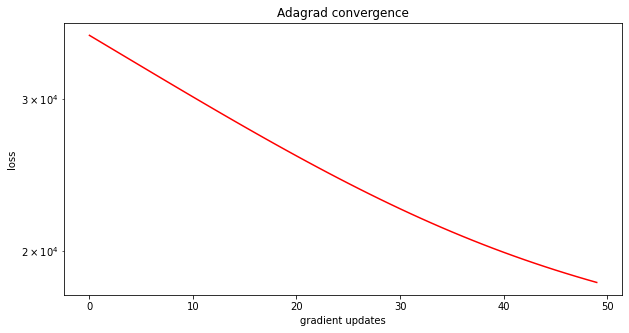

In [49]:
_, d = train_inputs.shape
w, losses = grad_descent(lambda weight: logistic(weight, train_inputs, train_labels), np.random.rand(d), 0.0001, 500)

plt.figure(figsize=(10,5))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("gradient updates")
plt.ylabel("loss")
plt.title("Adagrad convergence")
print("Final train loss: %f" % losses[-1])

In [52]:
predictions = predict(w,test_inputs)

In [55]:
Average_Precision(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average Precision: 0.006135394434711171


In [56]:
Average_NDCG(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average NDCG: 0.07450796426590381


**XGBOOST with LambdaMART**

In [ ]:
import xgboost as xgb

In [ ]:
def collect_group_ids_1(sampled_qids):

  number_list = []
  helper_dict = {}

  for i in range(len(sampled_qids)):
    if(helper_dict.get(sampled_qids[i]) == None):
      helper_dict[sampled_qids[i]] = 1
    else:
      v = helper_dict.get(sampled_qids[i]) + 1
      helper_dict[sampled_qids[i]] = v

  for key in helper_dict:
    number_list.append(helper_dict.get(key))
      
  return number_list

In [ ]:
train_groupd_ids = collect_group_ids_1(sampled_qids)

In [ ]:
def collect_group_ids_2(test_relevant_passages_dict):
  number_list = []

  for key in test_relevant_passages_dict:
    passages = test_relevant_passages_dict.get(key)
    number_list.append(len(passages[0]) + len(passages[1]))

  return number_list

In [ ]:
test_group_ids = collect_group_ids_2(test_relevant_passages_dict)

In [ ]:
model = xgb.XGBRanker(  
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=4, 
    n_estimators=500, 
    subsample=0.5 
    )

In [ ]:
model = model.fit(train_inputs, sampled_labels, group=train_groupd_ids, verbose=False)

In [ ]:
def get_XGBoost_predictions(model,test_relevant_passages_dict,test_inputs):

  result = []

  index = 1
  for key in test_relevant_passages_dict:
    l = test_relevant_passages_dict.get(key)
    group_input = []
    indexes = []
    for (_,i) in l[0] + l[1]:
      indexes.append(i)
      group_input.append(test_inputs[i])
    group_input = np.array(group_input)
    #print(group_input.shape)
    preds = model.predict(group_input)
    for i in range(len(indexes)):
      result.append((indexes[i],preds[i]))

  ## reorder the predictions
  result = sorted(result, key=lambda tup: tup[0], reverse = False)

  final_result = []
  for (_,p) in result:
    final_result.append(p)

  return final_result

In [ ]:
predictions = get_XGBoost_predictions(model,test_relevant_passages_dict,test_inputs)

In [ ]:
Average_Precision(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

In [ ]:
Average_NDCG(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

**Neural Network**

In [45]:
train_passages = joblib.load('drive/MyDrive/Vectors/train_inputs_passages')
train_queries = joblib.load('drive/MyDrive/Vectors/train_inputs_queries')
test_passages = joblib.load('drive/MyDrive/Vectors/test_inputs_passages')
test_queries = joblib.load('drive/MyDrive/Vectors/test_inputs_queries')

train_labels = np.array(joblib.load('drive/MyDrive/Vectors/train_labels'))
test_labels = joblib.load('drive/MyDrive/Vectors/test_labels')

In [46]:
print(train_passages.shape)
print(train_queries.shape)
print(test_passages.shape)
print(test_queries.shape)
print(train_labels.shape)
print(test_labels.shape)

(27713, 138)
(27713, 138)
(1103039, 138)
(1103039, 138)
(27713,)
(1103039,)
